# Anomaly Detection in Time Series

- Types of Anomaly detection
- Mean Absolute Deviation(MAD)
- Isolation Forest
- Local Outlier Factor(LOF)

## Use case:

Using real-life data on CPU utilization of an AWS EC2 Instance in the cloud. Data recorded every 5 minutes, starting from the 14th of February at 14:30PM. The dataset contains 4032 data points. It is available through the Numenta Anomaly Benchmark(NAB) repository under the AGPL-3.0 License.

Dataset: [link](https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv)

Labels: [link](https://github.com/numenta/NAB/blob/master/labels/combined_labels.json)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/ec2_cpu_utilization_24ae8d.csv")
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


Labels taken from the `combined_labels.json` file for ec2_cpu_utilization_24ae8d.csv


```
"realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv": [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ],
```



In [ ]:
anomalies_timestamp = ["2014-02-26 22:05:00",
        "2014-02-27 17:15:00"]

In [ ]:
# convert date column to TimeStamp
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [ ]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1

df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [ ]:
# add an anomaly label:
# where 1 is an in-lier meaning it is not an anomaly, -1 will be an anomaly

# Add an 'is_anomaly' column with default value 1
df["is_anomaly"] = 1

# Set 'is_anomaly' to -1 for rows with timestamps in anomalies_timestamp
df.loc[df["timestamp"].isin(anomalies_timestamp), "is_anomaly"] = -1

df.head()

,timestamp,value,is_anomaly,z-score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,-1
1,2014-02-14 14:35:00,0.134,1,0.0000,-1
2,2014-02-14 14:40:00,0.134,1,0.0000,-1
3,2014-02-14 14:45:00,0.134,1,0.0000,-1
4,2014-02-14 14:50:00,0.134,1,0.0000,-1


In [ ]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

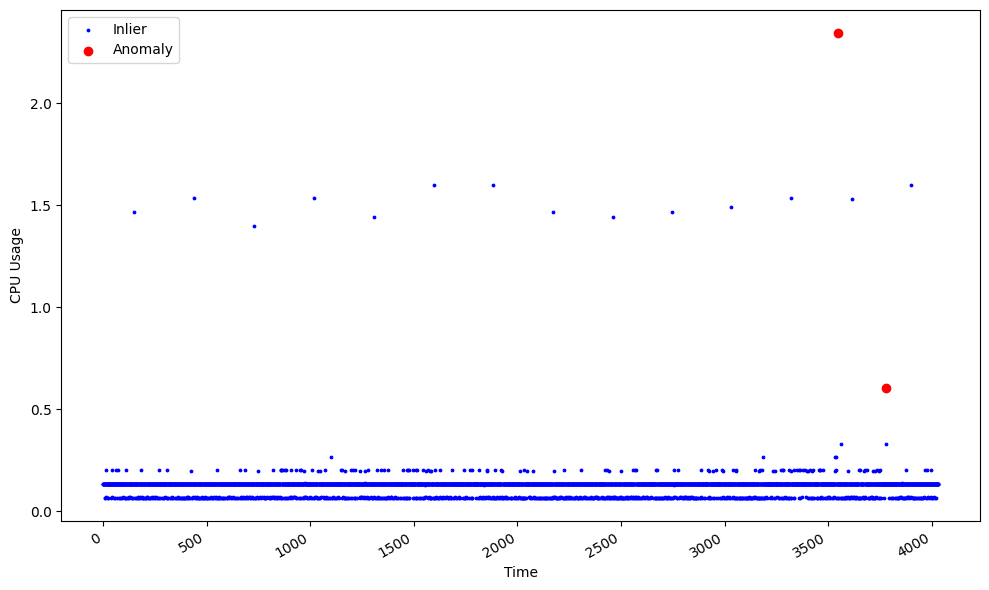

In [ ]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df["value"], color="blue", s=3, label="Inlier")
ax.scatter(anomaly_df.index, anomaly_df["value"], color="red", label="Anomaly")

ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage")
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Baseline solution: Mean Absolute Deviation

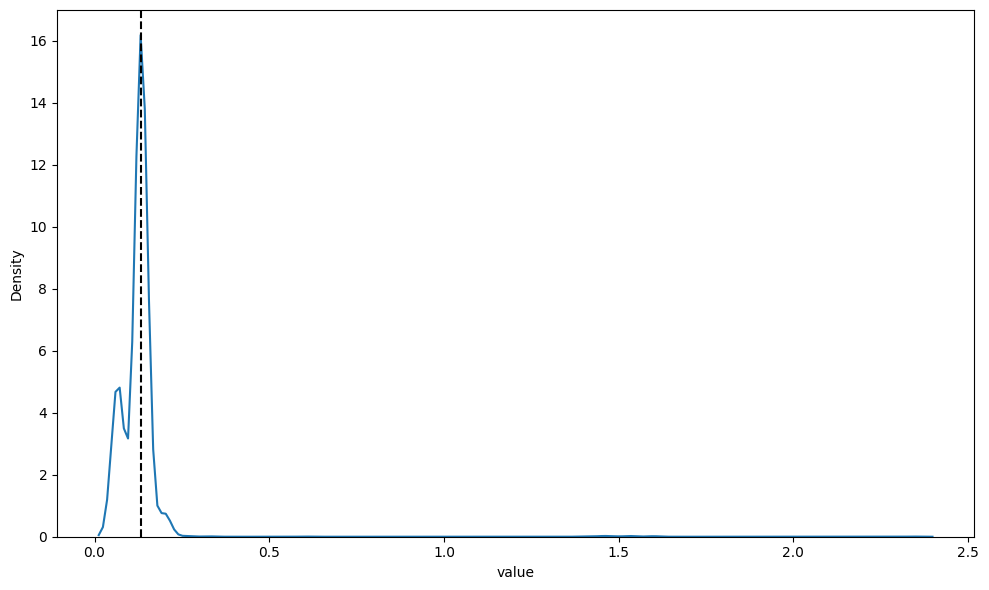

In [ ]:
# plotting the distribution of the data

sns.kdeplot(df["value"]);
plt.grid(False)
plt.axvline(0.134, 0, 1, c="black", ls="--")
plt.tight_layout()

The horizontal line which indicates the median also matches the peak which means that a big proportion of the data falls right on the median, and its not a normal distribution sinceit skewed to the left, hence the MAD would not work well in this case but we try it regardless.

In [ ]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df["value"])
median = np.median(df["value"])

print(f"MAD: {mad}")
print(f"Median: {median}")

# function to compute robust Z-score
def get_robust_z_score(x):
  return .6745*(x-median)/mad

MAD: 0.0020000000000000018
Median: 0.134


Our `median_abs_deviation` is 0.002 which is very close to zero and since its so small, any point that is slightly off from the median either under or over the median will probably be flagged as an outlier.

Note that we are dividing by the median_abs_deviation, which in this case is 0.002, a very small number. Consequently, our z-score will be very large. Even if we set a threshold around 3 or 3.5, the z-score is likely to be so high that any value slightly deviating from the median will be flagged as an outlier.

In [ ]:
# compute the robust Z-score for each sample
df["z-score"] = df["value"].apply(get_robust_z_score)

df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [ ]:
# Determine if its an anomaly depending on the Z-score
# Using a Threshold of 3.5

df["baseline"] = 1
df.loc[df["z-score"] >= 3.5, "baseline"] = -1
df.loc[df["z-score"] <= -3.5, "baseline"] = -1

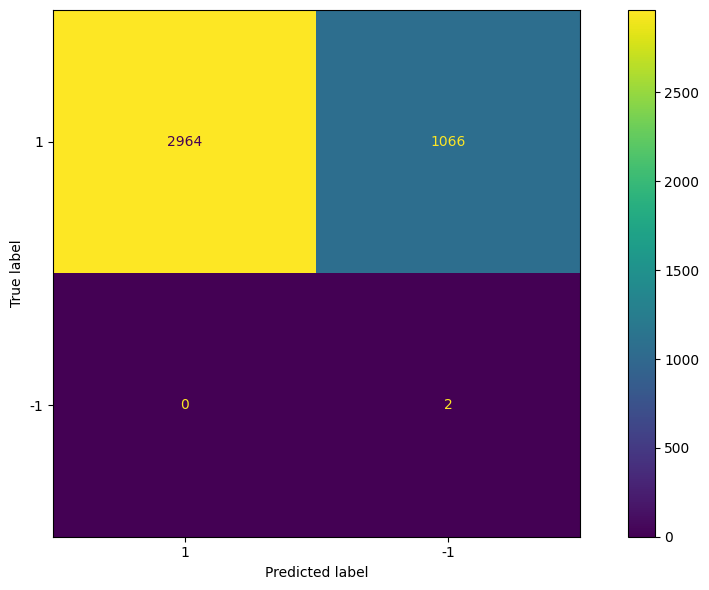

In [ ]:
# Evaluation using confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

display_cm.plot();

plt.grid(False)
plt.tight_layout()

Overall, the performance was not ideal. As you can see, the robust z-score method correctly identified the two outliers in our data, which is reflected in the number shown in the bottom right corner. This is a positive outcome, as the method successfully detected the actual outliers.

However, it also flagged a significant amount of normal data as outliers. For instance, we have predicted labels of -1 for many data points where the true label is 1, indicating that the model incorrectly labeled normal data as outliers. This was somewhat expected due to the flat values in our dataset and the median_abs_deviation being very close to zero. As a result, any slight deviation from the median was flagged as an outlier.

Using this method in our specific case doesn't make much sense because the data does not follow a normal distribution and has values close to zero. However, now you know how to implement this method, and it may work better in different scenarios. At least, you now have the knowledge to apply this baseline method if you encounter a suitable situation in the future.

## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
# split the data(keep one anomaly in the test set)

train = df[:3550]
test = df[3550:]

In [ ]:
# contamination level
contamination = 1/len(train)

# initialize model
iso_forest = IsolationForest(contamination=contamination, random_state=42)

# reshape Xtrain to fit the model
X_train = train['value'].values.reshape(-1,1)

# fit the model
iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [ ]:
# make predictions on reshaped test data
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

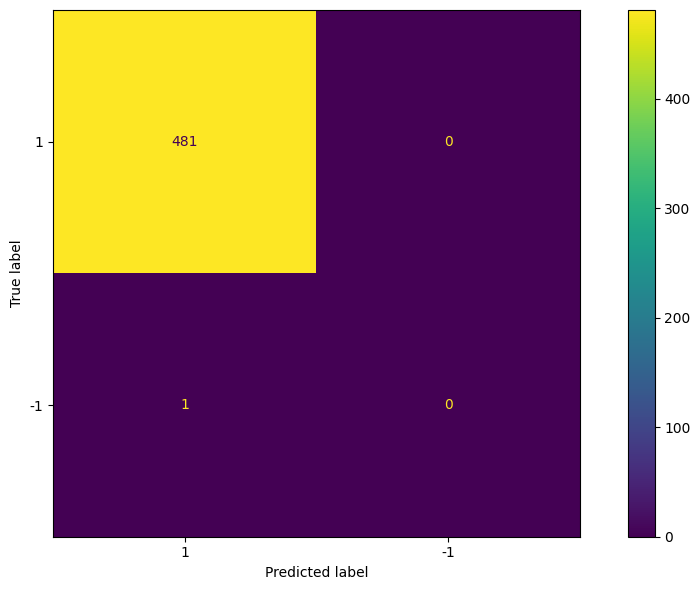

In [ ]:
# Evaluation
cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])

display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

display_cm.plot();

plt.grid(False)
plt.tight_layout()

Looking at the confusion matrix, we can see that the model did not manage to identify the new anomaly. Ideally, we would expect a one at the bottom right corner, indicating a correctly identified anomaly. However, this is not the case.

The model predicted that all instances in the test set are inliers, meaning it did not detect any anomalies. In reality, there is one anomaly, but the predicted label is 1 while the true label is -1. This indicates that the Isolation Forest model failed to identify the new outlier in the data.

## Local outlier factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True) #set to True since we want to make a prediction

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [ ]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

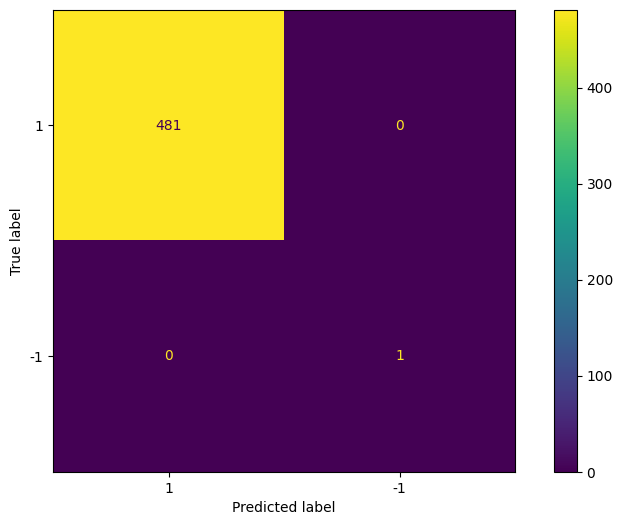

In [ ]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

display_cm.plot();

As you can see, the Local Outlier Factor (LOF) was able to identify the incoming anomaly in the dataset effectively. The confusion matrix now shows a perfect result: all inliers are correctly labeled, and the one anomaly is also correctly identified.

Specifically, there are zeros at the top right and bottom left of the matrix, indicating no false positives or false negatives. Everything predicted as an inlier is indeed an inlier, and the single anomaly was correctly labeled. For this situation, the Local Outlier Factor turned out to be the best model.
